In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
from collections import Counter
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping, TerminateOnNaN
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import multiprocessing as mp
import datetime
import codecs, json
import corner
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport multiprocessing_modules
%aimport plotting
%aimport model_setup
from data_processing import *
from multiprocessing_modules import train_net, init
from plotting import *
from model_setup import *

np.random.seed(999)
random.seed(999)

Using TensorFlow backend.


In [ ]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

In [36]:
a = '{:.1e}'.format(2.4e7)
print(a)

2.4e+07


## Load an existing model

In [ ]:
model = load_model()

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [6]:
mode = 'test' # 'train', 'val, 'test'

In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
print(a)
b = np.array([[5],[5],[5]])
print(b)
print(a*b)

In [14]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               sample_weight=training_data_dict['test_weights'], verbose=1)
tot_score = norm_scores[0]
predicted_points = predict_points(model, training_data_dict, data_type = mode, original_units=True)
title = 'Inputs: %s\n%.1e train points, test mse %.3e, %s data' % (', '.join(input_features), train_size, tot_score, mode)

40000/40000 [==============================] - 3s 86us/step


In [ ]:
### Standard plots
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode,
                                   predicted_points = predicted_points)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

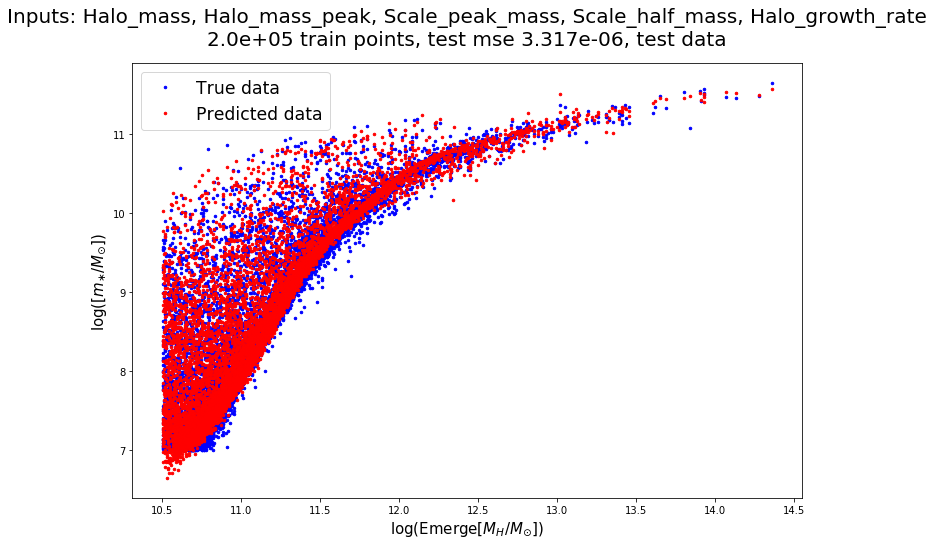

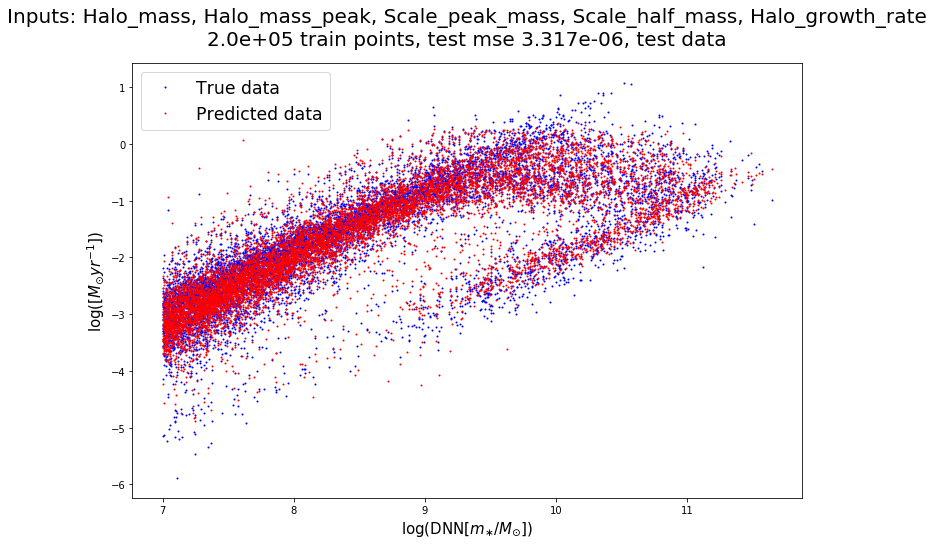

In [21]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [ ]:
### Save the figures
date_string = datetime.datetime.now().strftime('%H-%M_%Y-%m-%d')
fig1.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Set model parameters

In [2]:
### General parameters
nr_steps = 1e4
nr_repetitions = 1
total_set_size = 2.9e5
train_size = 2e5
val_size = .5e5
test_size = .4e5
batch_size = 1e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'zero_mean_unit_std'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']#, 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0]#,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 100
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nr_layers = 10
activation_function = 'tanh' # 'tanh', 'leaky_relu'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 10
reg_strength = 0


## Load data

In [3]:
# load the selected galaxyfile
galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, outputs_to_weigh=outputs_to_weigh, 
                                       weigh_by_redshift=weigh_by_redshift,
                                       total_set_size=int(total_set_size), train_size=int(train_size), val_size=int(val_size), test_size=int(test_size), 
                                       use_emerge_targets=True)
galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [4]:
model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, activation_function, 
                         output_activation, reg_strength, clipvalue=.001)


In [ ]:
model.summary()

## Train model

In [5]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
#file_path = models_path + "model_checkpoint.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True, mode='min', period=10)
#callbacks_list = [earlystop, checkpoint]
callbacks_list = [earlystop]

# train_weights, val_weights, test_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, weigh_by_redshift=weigh_by_redshift)

for i_rep in range(1, nr_repetitions+1):
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], training_data_dict['val_weights']), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=training_data_dict['train_weights'], verbose=1)

Train on 200000 samples, validate on 50000 samples
Epoch 1/500
200000/200000 [==============================] - 4s 18us/step - loss: 1.9917e-05 - Stellar_mass_loss: 1.2771e-05 - SFR_loss: 7.1455e-06 - val_loss: 7.0302e-05 - val_Stellar_mass_loss: 4.7928e-05 - val_SFR_loss: 2.2374e-05
Epoch 2/500
200000/200000 [==============================] - 1s 3us/step - loss: 1.4231e-05 - Stellar_mass_loss: 9.4852e-06 - SFR_loss: 4.7459e-06 - val_loss: 5.3177e-05 - val_Stellar_mass_loss: 3.7487e-05 - val_SFR_loss: 1.5689e-05
Epoch 3/500
200000/200000 [==============================] - 1s 3us/step - loss: 1.0657e-05 - Stellar_mass_loss: 7.3429e-06 - SFR_loss: 3.3140e-06 - val_loss: 4.0225e-05 - val_Stellar_mass_loss: 2.9473e-05 - val_SFR_loss: 1.0752e-05
Epoch 4/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.7924e-06 - Stellar_mass_loss: 5.3782e-06 - SFR_loss: 2.4142e-06 - val_loss: 2.9563e-05 - val_Stellar_mass_loss: 2.1019e-05 - val_SFR_loss: 8.5441e-06
Epoch 5/500
2000

Epoch 36/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.3905e-06 - Stellar_mass_loss: 1.8945e-07 - SFR_loss: 1.2011e-06 - val_loss: 5.5447e-06 - val_Stellar_mass_loss: 8.7137e-07 - val_SFR_loss: 4.6733e-06
Epoch 37/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.3749e-06 - Stellar_mass_loss: 1.8553e-07 - SFR_loss: 1.1894e-06 - val_loss: 5.4825e-06 - val_Stellar_mass_loss: 8.5630e-07 - val_SFR_loss: 4.6262e-06
Epoch 38/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.3594e-06 - Stellar_mass_loss: 1.8247e-07 - SFR_loss: 1.1769e-06 - val_loss: 5.4195e-06 - val_Stellar_mass_loss: 8.4042e-07 - val_SFR_loss: 4.5791e-06
Epoch 39/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.3442e-06 - Stellar_mass_loss: 1.7877e-07 - SFR_loss: 1.1654e-06 - val_loss: 5.3613e-06 - val_Stellar_mass_loss: 8.2702e-07 - val_SFR_loss: 4.5343e-06
Epoch 40/500
200000/200000 [==============================] - 0s

200000/200000 [==============================] - 0s 2us/step - loss: 1.0834e-06 - Stellar_mass_loss: 1.3099e-07 - SFR_loss: 9.5241e-07 - val_loss: 4.3044e-06 - val_Stellar_mass_loss: 5.7460e-07 - val_SFR_loss: 3.7298e-06
Epoch 72/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0804e-06 - Stellar_mass_loss: 1.3018e-07 - SFR_loss: 9.5024e-07 - val_loss: 4.2917e-06 - val_Stellar_mass_loss: 5.7540e-07 - val_SFR_loss: 3.7163e-06
Epoch 73/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0778e-06 - Stellar_mass_loss: 1.2981e-07 - SFR_loss: 9.4804e-07 - val_loss: 4.2780e-06 - val_Stellar_mass_loss: 5.6993e-07 - val_SFR_loss: 3.7081e-06
Epoch 74/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0752e-06 - Stellar_mass_loss: 1.2967e-07 - SFR_loss: 9.4548e-07 - val_loss: 4.2690e-06 - val_Stellar_mass_loss: 5.6727e-07 - val_SFR_loss: 3.7017e-06
Epoch 75/500
200000/200000 [==============================] - 0s 2us/step - l

200000/200000 [==============================] - 0s 2us/step - loss: 1.0170e-06 - Stellar_mass_loss: 1.2507e-07 - SFR_loss: 8.9192e-07 - val_loss: 4.0277e-06 - val_Stellar_mass_loss: 5.3576e-07 - val_SFR_loss: 3.4919e-06
Epoch 107/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0143e-06 - Stellar_mass_loss: 1.2571e-07 - SFR_loss: 8.8857e-07 - val_loss: 4.0319e-06 - val_Stellar_mass_loss: 5.4611e-07 - val_SFR_loss: 3.4857e-06
Epoch 108/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0133e-06 - Stellar_mass_loss: 1.2545e-07 - SFR_loss: 8.8785e-07 - val_loss: 4.0194e-06 - val_Stellar_mass_loss: 5.3591e-07 - val_SFR_loss: 3.4835e-06
Epoch 109/500
200000/200000 [==============================] - 0s 2us/step - loss: 1.0122e-06 - Stellar_mass_loss: 1.2546e-07 - SFR_loss: 8.8674e-07 - val_loss: 4.0132e-06 - val_Stellar_mass_loss: 5.3960e-07 - val_SFR_loss: 3.4736e-06
Epoch 110/500
200000/200000 [==============================] - 0s 2us/step

Epoch 141/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.5968e-07 - Stellar_mass_loss: 1.2599e-07 - SFR_loss: 8.3369e-07 - val_loss: 3.8116e-06 - val_Stellar_mass_loss: 5.4212e-07 - val_SFR_loss: 3.2695e-06
Epoch 142/500
200000/200000 [==============================] - 1s 3us/step - loss: 9.5772e-07 - Stellar_mass_loss: 1.2550e-07 - SFR_loss: 8.3222e-07 - val_loss: 3.7913e-06 - val_Stellar_mass_loss: 5.3575e-07 - val_SFR_loss: 3.2555e-06
Epoch 143/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.5911e-07 - Stellar_mass_loss: 1.2626e-07 - SFR_loss: 8.3284e-07 - val_loss: 3.7982e-06 - val_Stellar_mass_loss: 5.4486e-07 - val_SFR_loss: 3.2534e-06
Epoch 144/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.5607e-07 - Stellar_mass_loss: 1.2601e-07 - SFR_loss: 8.3006e-07 - val_loss: 3.7785e-06 - val_Stellar_mass_loss: 5.3773e-07 - val_SFR_loss: 3.2408e-06
Epoch 145/500
200000/200000 [==============================]

Epoch 176/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.0414e-07 - Stellar_mass_loss: 1.2546e-07 - SFR_loss: 7.7868e-07 - val_loss: 3.5755e-06 - val_Stellar_mass_loss: 5.3525e-07 - val_SFR_loss: 3.0403e-06
Epoch 177/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.0406e-07 - Stellar_mass_loss: 1.2512e-07 - SFR_loss: 7.7893e-07 - val_loss: 3.5819e-06 - val_Stellar_mass_loss: 5.3613e-07 - val_SFR_loss: 3.0457e-06
Epoch 178/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.0105e-07 - Stellar_mass_loss: 1.2475e-07 - SFR_loss: 7.7630e-07 - val_loss: 3.5749e-06 - val_Stellar_mass_loss: 5.3830e-07 - val_SFR_loss: 3.0366e-06
Epoch 179/500
200000/200000 [==============================] - 0s 2us/step - loss: 9.0034e-07 - Stellar_mass_loss: 1.2522e-07 - SFR_loss: 7.7512e-07 - val_loss: 3.5495e-06 - val_Stellar_mass_loss: 5.3163e-07 - val_SFR_loss: 3.0179e-06
Epoch 180/500
200000/200000 [==============================]

Epoch 211/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.5083e-07 - Stellar_mass_loss: 1.2260e-07 - SFR_loss: 7.2822e-07 - val_loss: 3.3637e-06 - val_Stellar_mass_loss: 5.1766e-07 - val_SFR_loss: 2.8460e-06
Epoch 212/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.5266e-07 - Stellar_mass_loss: 1.2290e-07 - SFR_loss: 7.2977e-07 - val_loss: 3.3605e-06 - val_Stellar_mass_loss: 5.1497e-07 - val_SFR_loss: 2.8456e-06
Epoch 213/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.4887e-07 - Stellar_mass_loss: 1.2287e-07 - SFR_loss: 7.2600e-07 - val_loss: 3.3559e-06 - val_Stellar_mass_loss: 5.1505e-07 - val_SFR_loss: 2.8408e-06
Epoch 214/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.4808e-07 - Stellar_mass_loss: 1.2276e-07 - SFR_loss: 7.2532e-07 - val_loss: 3.3510e-06 - val_Stellar_mass_loss: 5.1796e-07 - val_SFR_loss: 2.8331e-06
Epoch 215/500
200000/200000 [==============================]

Epoch 246/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.0733e-07 - Stellar_mass_loss: 1.2102e-07 - SFR_loss: 6.8631e-07 - val_loss: 3.1822e-06 - val_Stellar_mass_loss: 5.0360e-07 - val_SFR_loss: 2.6786e-06
Epoch 247/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.0472e-07 - Stellar_mass_loss: 1.2089e-07 - SFR_loss: 6.8383e-07 - val_loss: 3.1992e-06 - val_Stellar_mass_loss: 5.1222e-07 - val_SFR_loss: 2.6870e-06
Epoch 248/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.0452e-07 - Stellar_mass_loss: 1.2104e-07 - SFR_loss: 6.8348e-07 - val_loss: 3.1645e-06 - val_Stellar_mass_loss: 5.0303e-07 - val_SFR_loss: 2.6615e-06
Epoch 249/500
200000/200000 [==============================] - 0s 2us/step - loss: 8.0179e-07 - Stellar_mass_loss: 1.2066e-07 - SFR_loss: 6.8112e-07 - val_loss: 3.1644e-06 - val_Stellar_mass_loss: 5.0866e-07 - val_SFR_loss: 2.6557e-06
Epoch 250/500
200000/200000 [==============================]

Epoch 281/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.7096e-07 - Stellar_mass_loss: 1.2055e-07 - SFR_loss: 6.5041e-07 - val_loss: 3.0194e-06 - val_Stellar_mass_loss: 4.8905e-07 - val_SFR_loss: 2.5303e-06
Epoch 282/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.6891e-07 - Stellar_mass_loss: 1.1986e-07 - SFR_loss: 6.4905e-07 - val_loss: 3.0296e-06 - val_Stellar_mass_loss: 4.9322e-07 - val_SFR_loss: 2.5363e-06
Epoch 283/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.6760e-07 - Stellar_mass_loss: 1.1925e-07 - SFR_loss: 6.4836e-07 - val_loss: 3.0133e-06 - val_Stellar_mass_loss: 4.9086e-07 - val_SFR_loss: 2.5224e-06
Epoch 284/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.6634e-07 - Stellar_mass_loss: 1.1998e-07 - SFR_loss: 6.4636e-07 - val_loss: 3.0108e-06 - val_Stellar_mass_loss: 4.8946e-07 - val_SFR_loss: 2.5213e-06
Epoch 285/500
200000/200000 [==============================]

Epoch 316/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.4241e-07 - Stellar_mass_loss: 1.1842e-07 - SFR_loss: 6.2399e-07 - val_loss: 2.9261e-06 - val_Stellar_mass_loss: 4.8383e-07 - val_SFR_loss: 2.4422e-06
Epoch 317/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.4201e-07 - Stellar_mass_loss: 1.1830e-07 - SFR_loss: 6.2371e-07 - val_loss: 2.9111e-06 - val_Stellar_mass_loss: 4.8357e-07 - val_SFR_loss: 2.4275e-06
Epoch 318/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.3759e-07 - Stellar_mass_loss: 1.1748e-07 - SFR_loss: 6.2012e-07 - val_loss: 2.8996e-06 - val_Stellar_mass_loss: 4.8611e-07 - val_SFR_loss: 2.4135e-06
Epoch 319/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.3691e-07 - Stellar_mass_loss: 1.1781e-07 - SFR_loss: 6.1910e-07 - val_loss: 2.9039e-06 - val_Stellar_mass_loss: 4.8702e-07 - val_SFR_loss: 2.4169e-06
Epoch 320/500
200000/200000 [==============================]

Epoch 351/500
200000/200000 [==============================] - 1s 3us/step - loss: 7.1607e-07 - Stellar_mass_loss: 1.1683e-07 - SFR_loss: 5.9925e-07 - val_loss: 2.8273e-06 - val_Stellar_mass_loss: 4.8683e-07 - val_SFR_loss: 2.3405e-06
Epoch 352/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.1655e-07 - Stellar_mass_loss: 1.1698e-07 - SFR_loss: 5.9957e-07 - val_loss: 2.8265e-06 - val_Stellar_mass_loss: 4.8777e-07 - val_SFR_loss: 2.3387e-06
Epoch 353/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.1594e-07 - Stellar_mass_loss: 1.1796e-07 - SFR_loss: 5.9797e-07 - val_loss: 2.8213e-06 - val_Stellar_mass_loss: 4.8377e-07 - val_SFR_loss: 2.3376e-06
Epoch 354/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.1391e-07 - Stellar_mass_loss: 1.1656e-07 - SFR_loss: 5.9736e-07 - val_loss: 2.8181e-06 - val_Stellar_mass_loss: 4.8114e-07 - val_SFR_loss: 2.3370e-06
Epoch 355/500
200000/200000 [==============================]

Epoch 386/500
200000/200000 [==============================] - 0s 2us/step - loss: 7.0067e-07 - Stellar_mass_loss: 1.1600e-07 - SFR_loss: 5.8467e-07 - val_loss: 2.7773e-06 - val_Stellar_mass_loss: 4.7875e-07 - val_SFR_loss: 2.2986e-06
Epoch 387/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.9997e-07 - Stellar_mass_loss: 1.1677e-07 - SFR_loss: 5.8320e-07 - val_loss: 2.7556e-06 - val_Stellar_mass_loss: 4.7786e-07 - val_SFR_loss: 2.2777e-06
Epoch 388/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.9923e-07 - Stellar_mass_loss: 1.1615e-07 - SFR_loss: 5.8308e-07 - val_loss: 2.7468e-06 - val_Stellar_mass_loss: 4.7524e-07 - val_SFR_loss: 2.2716e-06
Epoch 389/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.9907e-07 - Stellar_mass_loss: 1.1658e-07 - SFR_loss: 5.8249e-07 - val_loss: 2.7588e-06 - val_Stellar_mass_loss: 4.7678e-07 - val_SFR_loss: 2.2820e-06
Epoch 390/500
200000/200000 [==============================]

Epoch 421/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.8729e-07 - Stellar_mass_loss: 1.1536e-07 - SFR_loss: 5.7193e-07 - val_loss: 2.7163e-06 - val_Stellar_mass_loss: 4.7121e-07 - val_SFR_loss: 2.2451e-06
Epoch 422/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.8645e-07 - Stellar_mass_loss: 1.1526e-07 - SFR_loss: 5.7118e-07 - val_loss: 2.6914e-06 - val_Stellar_mass_loss: 4.7143e-07 - val_SFR_loss: 2.2199e-06
Epoch 423/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.8409e-07 - Stellar_mass_loss: 1.1482e-07 - SFR_loss: 5.6927e-07 - val_loss: 2.7105e-06 - val_Stellar_mass_loss: 4.7486e-07 - val_SFR_loss: 2.2357e-06
Epoch 424/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.8367e-07 - Stellar_mass_loss: 1.1476e-07 - SFR_loss: 5.6891e-07 - val_loss: 2.6989e-06 - val_Stellar_mass_loss: 4.7572e-07 - val_SFR_loss: 2.2232e-06
Epoch 425/500
200000/200000 [==============================]

Epoch 456/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.7330e-07 - Stellar_mass_loss: 1.1440e-07 - SFR_loss: 5.5890e-07 - val_loss: 2.6546e-06 - val_Stellar_mass_loss: 4.7268e-07 - val_SFR_loss: 2.1820e-06
Epoch 457/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.7249e-07 - Stellar_mass_loss: 1.1394e-07 - SFR_loss: 5.5855e-07 - val_loss: 2.6896e-06 - val_Stellar_mass_loss: 4.6878e-07 - val_SFR_loss: 2.2208e-06
Epoch 458/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.7485e-07 - Stellar_mass_loss: 1.1403e-07 - SFR_loss: 5.6082e-07 - val_loss: 2.6596e-06 - val_Stellar_mass_loss: 4.6647e-07 - val_SFR_loss: 2.1931e-06
Epoch 459/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.7230e-07 - Stellar_mass_loss: 1.1358e-07 - SFR_loss: 5.5872e-07 - val_loss: 2.6356e-06 - val_Stellar_mass_loss: 4.5916e-07 - val_SFR_loss: 2.1764e-06
Epoch 460/500
200000/200000 [==============================]

Epoch 491/500
200000/200000 [==============================] - 1s 3us/step - loss: 6.6261e-07 - Stellar_mass_loss: 1.1192e-07 - SFR_loss: 5.5069e-07 - val_loss: 2.6135e-06 - val_Stellar_mass_loss: 4.5980e-07 - val_SFR_loss: 2.1537e-06
Epoch 492/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.6257e-07 - Stellar_mass_loss: 1.1197e-07 - SFR_loss: 5.5060e-07 - val_loss: 2.6195e-06 - val_Stellar_mass_loss: 4.6578e-07 - val_SFR_loss: 2.1537e-06
Epoch 493/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.6259e-07 - Stellar_mass_loss: 1.1324e-07 - SFR_loss: 5.4935e-07 - val_loss: 2.6096e-06 - val_Stellar_mass_loss: 4.5754e-07 - val_SFR_loss: 2.1520e-06
Epoch 494/500
200000/200000 [==============================] - 0s 2us/step - loss: 6.6321e-07 - Stellar_mass_loss: 1.1222e-07 - SFR_loss: 5.5100e-07 - val_loss: 2.6266e-06 - val_Stellar_mass_loss: 4.6105e-07 - val_SFR_loss: 2.1655e-06
Epoch 495/500
200000/200000 [==============================]

#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Input parameter search

#### Do a batch run to see which input parameters gives the best score

In [ ]:
### General parameters
nr_steps = 5e4
batch_size = .5e4
total_set_size = 3e4 # how many examples will be used for training+validation+testing
train_size = 2.5e4
val_size = .25e4
test_size = .25e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = True

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 20
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

### Network parameters
nr_layers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 10
reg_strength = 0#1e-5

# Batch run parameters
core_input_features = ['Halo_mass', 'Redshift']
tested_input_features = ['Scale_half_mass', 'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [1, 2, 3, 4]
nr_runs_per_comb = 3


verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activation_function,
    'neurons_per_layer': [neurons_per_layer],
    'nr_hidden_layers': [nr_layers],
    'output_activation_function': output_activation,
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs (sum of test losses).'+\
    ' The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss].'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            

            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts,
                                                   int(total_set_size), int(train_size), int(val_size), int(test_size))
            training_data_dict = normalise_data(training_data_dict, norm)
            
            earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                      patience=early_stop_patience, verbose=1, mode='auto')
            callbacks_list = [earlystop]

            train_weights, val_weights, test_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                                     weigh_by_redshift=weigh_by_redshift)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, 
                                         activation_function, output_activation, reg_strength)

                # Fit the model

                history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                                    validation_data = (training_data_dict['input_val_dict'], 
                                    training_data_dict['output_val_dict'], val_weights), 
                                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                                    sample_weight=train_weights, verbose=verb)
                score = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'], 
                                       sample_weight=test_weights, verbose=verb)
                scores.append(score[0]) # take only the sum of the output losses (total loss)
                    

                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '3-6_total_inputs_redshift_growth'
tot_string = date_string + '-' + custom_string

with open('model_comparisons/' + tot_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '2018-06-20--09-52-20-3-6_total_inputs_redshift'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

#### Plot the results

In [ ]:
print(len(results_list[1][0]))
print(results_list[1][0])
results_list[0]['nr_extra_parameter_combinations']

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_losses = lst[1]
    avg_test_loss = np.mean(test_losses)
    title = ', '.join(lst[0]) + '\naverage test loss: {:.3e}'.format(avg_test_loss)

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_losses)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][1])

In [ ]:
### Get the X best performing input parameters
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.1]
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    best_test = np.amin(lst[1])
    test_results.append(best_test)
    
best_test_indices = np.argsort(test_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

nr_fixed_inputs = len(results_list[0]['fixed_input_features'])
collabel=('Input parameters', 'best test mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:nr_fixed_inputs])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([inputs, '{:.2e} (mean: {:.2e})'.format(test_results[best_test_indices[i]], 
                                                              np.mean(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
nr_columns = 10
collabel = ['Input parameter']
[collabel.append('{:d}'.format(i)) for i in range(1, nr_columns+1)]
collabel = tuple(collabel)
#collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(nr_columns):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:nr_columns]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on best out of 3 test scores' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.9])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search

In [ ]:
### Multiprocessing version

nr_folds = 3
total_set_size = 2e6
train_size = 1.5e6
val_size = .25e6
test_size = .25e6

input_features = ['Halo_mass', 'Redshift', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
same_n_points_per_redshift = False
weigh_by_redshift = True

nr_layers = [6, 8, 10]
neurons_per_layer = [6, 8, 10]
activation_functions = ['relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std']
output_norm = 'zero_mean_unit_std'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e4]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = nr_epochs / 10
batch_sizes = batch_sizes.tolist()
nr_epochs = nr_epochs.tolist()
early_stop_min_delta = 1e-20

progress_file = 'hyperparameter_searches/progress.txt'
n_processes = 28

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing five objects: [parameters, test_score, train_history, '+\
    'val_history, param_id]. The first one is ' + \
    'the parameters of the model. The second one is the test score of the final model'+\
    ' ' +\
    'The third one is the training' +\
    'loss history and the fourth one is the validation loss history. '+\
    'The fifth one is an id for the parameter combinations. If there are several runs for the same combs then they will have the same id.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds


    
with open(progress_file, 'w') as f:

    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on hyperparameters on ' + date_string_proper + '\n\n' + '0/{}'.format(tot_nr_runs))
    f.flush()

# load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)

param_combos = []
param_id = 0      # for identifying the same combinations of parameters

for i_act_fun, act_fun in enumerate(activation_functions):
    for i_reg_strength, reg_strength in enumerate(reg_strengths):
        for i_inp_norm, inp_norm in enumerate(input_norms): 
            norm = {'input': inp_norm,
                    'output': output_norm}
            for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                for i_nr_lay, nr_lay in enumerate(nr_layers):
                    for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                        param_id += 1
                        for fold in range(nr_folds):

                            params = [galaxies, data_keys, redshifts, total_set_size, train_size, val_size, test_size, 
                                      input_features, output_features, outputs_to_weigh, weigh_by_redshift, neur_per_lay, 
                                      nr_lay, act_fun, output_activation, norm, reg_strength, nr_epochs[i_batch_size], 
                                      batch_size, progress_file, verb, early_stop_min_delta, 
                                      early_stop_patience[i_batch_size], param_id]

                            param_combos.append(params)

write_lock = mp.Lock()
with mp.Pool(processes=n_processes, initializer=init, initargs=(write_lock,)) as pool:
    results = pool.map(train_net, param_combos)

results_list.extend(results)

with open(progress_file, 'a') as f:
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('\nBenchmark completed at ' + date_string_proper + '\n')
    f.flush()

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = 'first_search'
tot_string = date_string + '_' + custom_string
with open('hyperparameter_searches/' + tot_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:
### Load a result
loaded_list_string = '2018-06-28--16-46-48_first_search'
with open('hyperparameter_searches/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
contains_data_list = [lst[4] for lst in results_list[1:]]
contains_no_data_list = [not lst[4] for lst in results_list[1:]]
print('Number of parameter combinations that ended up exploding before val loss could be evaluated: {:d}'.format(
      np.sum(contains_data_list)))
print('Number of parameter combinations that contains at least one val loss data point: {:d}'.format(
      np.sum(contains_no_data_list)))
for comb_nr, lst in enumerate(results_list[1:]):
    
    if lst[4]:
        title = str(lst[0]) + '\n mean final validation score: {:.2e}$\pm${:.2e}'.format(lst[1][0], lst[1][1])
        train_losses = lst[2]
        val_losses = lst[3]

        #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

        # summarize history for loss
        fig = plt.figure(5, figsize=(12,12))
        for train_loss, val_loss in zip(train_losses, val_losses):
            plt.plot(range(1, len(train_loss)+1), train_loss, 'b')
            plt.plot(range(1, len(val_loss)+1), val_loss, 'r')
        plt.yscale('log')
        plt.title(title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
  #  else:
  #      print('No data here, boss')


In [ ]:
{'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
nr_lay_nans = []
neur_per_lay_nans = []
batch_size_nans = []
reg_strength_nans = []
inp_norm_nans = []
actfun_nans = []

for i_lst, lst in enumerate(results_list[1:]):

   # print(lst[2][0])
  #  print(len(lst[2][0]))
    if len(lst[2][0])%10 > 0:
        
        nr_lay_nans.append(lst[0]['nr_lay'])
        neur_per_lay_nans.append(lst[0]['neur_per_lay'])
        batch_size_nans.append(lst[0]['batch_size'])
        reg_strength_nans.append(lst[0]['reg_strength'])
        inp_norm_nans.append(lst[0]['inp_norm'])
        actfun_nans.append(lst[0]['act_fun'])
        
    #    print('object nr {}'.format(i_lst+1))
    
print('The occurrences of NaN value in the losses by input parameter')
print('nr_lays: ', dict(Counter(nr_lay_nans)))
print('neur_per_lay: ', dict(Counter(neur_per_lay_nans)))
print('batch_size: ', dict(Counter(batch_size_nans)))
print('reg_strength: ', dict(Counter(reg_strength_nans)))
print('inp_norm: ', dict(Counter(inp_norm_nans)))
print('act_fun: ', dict(Counter(actfun_nans)))

In [ ]:
['results_list[key] results_list[1][0]

In [ ]:
top_nr_of_parameter_combs = 10
#column_widths = [0.2, 0.1]
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    best_val = lst[1][2]
    val_results.append(best_val)
sort_indices = np.argsort(val_results)

fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)

collabel=('Hyperparameters', 'Best val mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    parameters = ', '.join(results_list[sort_indices[i]+1][0][:nr_fixed_inputs])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([inputs, '{:.2e} (mean: {:.2e})'.format(test_results[best_test_indices[i]], 
                                                              np.mean(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Old code

In [ ]:
### OLDDDDDDDDDDDDDDDDDDDDDDDDDD
nr_folds = 1
total_set_size = 7e4
train_size = 2.5e4
val_size = 2.5e4
test_size = 2e4

input_features = ['Halo_mass', 'Redshift', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
same_n_points_per_redshift = True
weigh_by_redshift = True

nr_layers = [6, 8, 10]
neurons_per_layer = [6, 8, 10]
activation_functions = ['relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std', 'zero_to_one']
output_norm = 'zero_mean_unit_std'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e2]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = nr_epochs / 1
batch_sizes = batch_sizes.tolist()
nr_epochs = nr_epochs.tolist()
early_stop_min_delta = 1e-20

verb = 1 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing four objects. The first one is ' + \
    'the parameters of the model. The second one is a list with 0: the mean best val score obtained based on the '+\
    'k folds, 1: the std for these scores, and 2: the best validation score from all folds and histories.' +\
    'The third one is the training' +\
    'loss histories for the different folds and the fourth one is the validation loss histories on the different folds.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds
run_counter = 0 # to keep track of how many combinations I've gone through

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            for i_inp_norm, inp_norm in enumerate(input_norms):
                norm = {'input': inp_norm,
                        'output': output_norm}
                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                f.write(date_string_proper + '  Starting new constant unit\n\n')
                f.flush()
                for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                    for i_nr_lay, nr_lay in enumerate(nr_layers):
                        for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                            
                            earlystop = EarlyStopping(monitor='val_loss', min_delta=early_stop_min_delta, 
                                                      patience=early_stop_patience[i_batch_size], verbose=1, mode='auto')
                            nan_termination = TerminateOnNaN()
                            callbacks_list = [earlystop, nan_termination]
                        
                            train_histories = []
                            val_histories = []
                            scores = []
                            
                            for fold in range(nr_folds):
                                
                                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                                run_counter += 1
                                f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                                f.flush()

                                ### Prepare the training data
                                
                                training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                                                       output_features, redshifts, int(total_set_size), 
                                                                       int(train_size), int(val_size), int(test_size))
                                #training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                #                                       output_features, redshifts, total_set_size, 
                                #                                       k_fold_cv=True, 
                                #                                       tot_cv_folds=nr_folds, cv_fold_nr=fold)
                                training_data_dict = normalise_data(training_data_dict, norm)
                                
                                # set data point weights
                                train_weights, val_weights, test_weights = get_weights(training_data_dict, 
                                                                                       output_features, 
                                                                                       outputs_to_weigh, 
                                                                                       weigh_by_redshift=
                                                                                                       weigh_by_redshift)
                   #             print(np.amax(train_weights['Stellar_mass']))
                   #             print(np.amin(train_weights['Stellar_mass']))
                   #             print(np.median(train_weights['Stellar_mass']))
                   #             print(np.amax(train_weights['SFR']))
                   #             print(np.amin(train_weights['SFR']))
                   #             print(np.median(train_weights['SFR']))
                                
                                model = standard_network(input_features, output_features, neur_per_lay, nr_lay, 
                                                         act_fun, output_activation, reg_strength, clipvalue=.1)
                                
                              #  get_layer_output = K.function([model.layers[0].input],
                              #                                    [model.layers[13].output])
                              #  layer_output = get_layer_output([training_data_dict['x_train'][:50,:]])[0]
                              #  print(layer_output)

                                # Fit the model
                                history = model.fit(x = training_data_dict['input_train_dict'], 
                                                    y = training_data_dict['output_train_dict'], 
                                                    validation_data = (training_data_dict['input_val_dict'], 
                                                    training_data_dict['output_val_dict'], val_weights), 
                                                    epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), 
                                                    callbacks=callbacks_list, sample_weight=train_weights, verbose=verb)

                                train_histories.append(history.history['loss'])
                                val_histories.append(history.history['val_loss'])
                                scores.append(np.amin(history.history['val_loss']))
                                
                            best_score = np.amin(scores)
                            mean_score = np.mean(scores)
                            score_std = np.std(scores)
                            total_score = [mean_score, score_std, best_score]
                            parameters = {'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                            results_list.append([parameters, total_score, train_histories, val_histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)